
<div class="note">
    <p style="margin-top: 0; margin-bottom: 0;">
        <img style="margin-top: 0; margin-bottom: 0; height: 2em;" class="inline-block mr-2 no-fancybox"
            src="https://upload.wikimedia.org/wikipedia/commons/3/38/Jupyter_logo.svg" alt="">
        This page is based on a Jupyter notebook.
<a href="./CooksMembraneFbar.ipynb" download="CooksMembraneFbar.ipynb"><img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" src="https://img.shields.io/static/v1?label=Download:&message=CooksMembraneFbar.ipynb&color=blue" /></a>
<a href="https://gitlab.opengeosys.org/ogs/ogs/-/blob/master/Tests/Data/LargeDeformation/CooksMembrane/CooksMembraneFbar.py"><img src="https://img.shields.io/static/v1?label=Source:&message=CooksMembraneFbar.py&color=brightgreen" class="no-fancybox"
        style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" /></a>
<a href="https://binder.opengeosys.org/v2/gh/bilke/binder-ogs-requirements/master?urlpath=git-pull%3Frepo=https://gitlab.opengeosys.org/ogs/ogs%26urlpath=lab/tree/ogs/Tests/Data/LargeDeformation/CooksMembrane/CooksMembraneFbar.py%26branch=master%26depth=1">
    <img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;"
        src="https://img.shields.io/static/v1?label=&message=Launch notebook&color=5c5c5c&logo=" />
</a></p></div>

$$
\newcommand{\J}{\text{J}}
\newcommand{\F}{\text{F}}
$$

# Cook's membrane example for nearly incompressible solid under large deformation

The example has been analyzed in many references, for example with the F-bar method in [1] and [2].
This example is also used as benchmark for [SmallDeformation](https://www.opengeosys.org/docs/benchmarks/small-deformations/cooksmembranefbar/). Hereby we analyze it again under finite strain assumption using the F-bar method for the total Lagrange formulation (see the attached [PDF](figures/F-bar-ogs.pdf) for its theory).
For the finite strain assumption, the constitutive law is replaced with a hyperelasticity one, the Neo-Hookean. The Neo-Hookean model defines an energy function as the sum of volumetric component $U_{\text{dil}}(\F)$ and deviatoric component $U_{\text{dev}}(\F)$ as
$$
\begin{align}
W(\F) = U_{\text{dil}}(\F) + U_{\text{dev}}(\F),
\end{align}
$$
where
$$
\begin{align}
& U_{\text{dil}}(\F) = \dfrac{1}{2} K (\det(\F)-1)^2\\
& U_{\text{dev}}(\F) = \dfrac{1}{2} G \left(\text{tr} (\det(\F)^{-\frac{2}{3}}\F\F^{\text{T}})-3\right)
\end{align}
$$
with $K$ the bulk modulus, and $G$ the shear modulus. The values of $K$ and $G$ are taken from references [1] and [2], which are $40.0942\cdot 10^{4}$ MPa and $80.1938$ MPa, respectively. For OGS input, the corresponding Young's modulus and Poisson ratio are 240.565 MPa, and 0.499, respectively.


## Reference

1. E.A. de Souza Neto, D. Perić, M. Dutko, D.R.J. Owen, [Design of simple low order finite elements for large strain analysis of nearly incompressible solids](https://doi.org/10.1016/0020-7683(95)00259-6), International Journal of Solids and Structures, Volume 33, Issues 20–22, 1996, Pages 3277-3296.

2. T. Elguedj, Y. Bazilevs, V.M. Calo, T.J.R. Hughes (2008),
 $\bar\B$ and $\bar{\text F}$ projection methods for nearly incompressible linear and non-linear elasticity and plasticity using higher-order NURBS elements, Computer Methods in Applied Mechanics and Engineering, 197(33–40), 2732-2762.


In [1]:
# Standard library imports
import os
from pathlib import Path

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import ogstools as ot

out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))

if not out_dir.exists():
    out_dir.mkdir(parents=True)

In [2]:
def get_top_uy(pvd_file_name):
    top_point = (48.0e-3, 60.0e-3, 0)
    mesh = ot.MeshSeries(out_dir / pvd_file_name)[-1]
    p_id = mesh.find_closest_point(top_point)
    return mesh.point_data["displacement"][p_id, 1]

In [3]:
def run_single_test(mesh_name, output_prefix, use_fbar=False, use_load_increment=False):
    prj = ot.Project(
        input_file="CooksMembrane.prj",
        output_file=out_dir / "modified.prj",
    )

    prj.replace_text(mesh_name, xpath="./mesh")
    if not use_fbar:
        prj.replace_text("none", xpath="./processes/process/f_bar")
    prj.replace_text(output_prefix, xpath="./time_loop/output/prefix")
    vtu_file_name = output_prefix + "_ts_1_t_1.000000.vtu"
    prj.replace_text(vtu_file_name, xpath="./test_definition/vtkdiff[1]/file")
    prj.replace_text(vtu_file_name, xpath="./test_definition/vtkdiff[2]/file")
    prj.replace_text(vtu_file_name, xpath="./test_definition/vtkdiff[3]/file")

    if use_load_increment:
        prj.replace_text(
            0.5,
            xpath="./time_loop/processes/process[1]/time_stepping/timesteps/pair/delta_t",
        )
        prj.replace_text(
            "FRamp",
            xpath="./process_variables/process_variable/boundary_conditions/boundary_condition[3]/parameter",
        )

    prj.write_input()
    prj.run_model(logfile=f"{out_dir}/out.txt", args=f"-o {out_dir} -m .")

    return get_top_uy(output_prefix + ".pvd")

In [4]:
nedges = [4, 10, 15, 20, 25, 30]
mesh_names = [f"mesh{n}.vtu" for n in [""] + [f"_n{ne}" for ne in nedges[1:]]]
load_increment_labels = [False, False, False, True, True, False]
output_prefices = [
    f"cooks_membrane_ld_{suffix}"
    for suffix in ["edge_div_4"] + [f"_refined_mesh_{ne}" for ne in nedges[1:]]
]

uys_at_top_fbar = []
for mesh_name, load_increment_label, output_prefix in zip(
    mesh_names, load_increment_labels, output_prefices
):
    uy_at_top = run_single_test(
        mesh_name,
        output_prefix,
        use_fbar=True,
        use_load_increment=load_increment_label,
    )
    uys_at_top_fbar.append(uy_at_top)

print(uys_at_top_fbar)

Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-all/Tests/Data/LargeDeformation/CooksMembrane/CooksMembraneFbar/modified.prj
Status: finished successfully.
Execution took 0.2729377746582031 s


Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-all/Tests/Data/LargeDeformation/CooksMembrane/CooksMembraneFbar/modified.prj
Status: finished successfully.
Execution took 0.42857980728149414 s


Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-all/Tests/Data/LargeDeformation/CooksMembrane/CooksMembraneFbar/modified.prj
Status: finished successfully.
Execution took 0.7334165573120117 s


Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-all/Tests/Data/LargeDeformation/CooksMembrane/CooksMembraneFbar/modified.prj
Status: finished successfully.
Execution took 1.0678541660308838 s


Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-all/Tests/Data/LargeDeformation/CooksMembrane/CooksMembraneFbar/modified.prj
Status: finished successfully.
Execution took 2.2875680923461914 s


Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-all/Tests/Data/LargeDeformation/CooksMembrane/CooksMembraneFbar/modified.prj
Status: finished successfully.
Execution took 2.446134328842163 s
[np.float64(0.006141383357237822), np.float64(0.0067462839553791044), np.float64(0.006824182826846709), np.float64(0.0068589364837969066), np.float64(0.006873125863968569), np.float64(0.006891409184390112)]


In [5]:
expected_uys_at_top_fbar = np.array(
    [
        0.006141383357250432,
        0.006746283955378773,
        0.0068241828268382505,
        0.0068589364838052315,
        0.006873125862208623,
        0.006891409184641067,
    ]
)
np.testing.assert_allclose(
    actual=uys_at_top_fbar, desired=expected_uys_at_top_fbar, atol=2e-4
)

In [6]:
output_prefices_non_fbar = [prefix + "_non_fbar" for prefix in output_prefices]

uys_at_top_non_fbar = []
for mesh_name, load_increment_label, output_prefix in zip(
    mesh_names, load_increment_labels, output_prefices_non_fbar
):
    uy_at_top = run_single_test(
        mesh_name,
        output_prefix,
        use_fbar=False,
        use_load_increment=load_increment_label,
    )
    uys_at_top_non_fbar.append(uy_at_top)

print(uys_at_top_non_fbar)

Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-all/Tests/Data/LargeDeformation/CooksMembrane/CooksMembraneFbar/modified.prj
Status: finished successfully.
Execution took 0.2297224998474121 s


Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-all/Tests/Data/LargeDeformation/CooksMembrane/CooksMembraneFbar/modified.prj
Status: finished successfully.
Execution took 0.2373490333557129 s


Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-all/Tests/Data/LargeDeformation/CooksMembrane/CooksMembraneFbar/modified.prj
Status: finished successfully.
Execution took 0.24918699264526367 s


Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-all/Tests/Data/LargeDeformation/CooksMembrane/CooksMembraneFbar/modified.prj
Status: finished successfully.
Execution took 0.3414590358734131 s


Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-all/Tests/Data/LargeDeformation/CooksMembrane/CooksMembraneFbar/modified.prj
Status: finished successfully.
Execution took 0.462064266204834 s


Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/e3EQ9HiK/0/ogs/build/release-all/Tests/Data/LargeDeformation/CooksMembrane/CooksMembraneFbar/modified.prj
Status: finished successfully.
Execution took 0.527446985244751 s
[np.float64(0.0022867221436878894), np.float64(0.002840692165858719), np.float64(0.0033745807476269576), np.float64(0.0038811997172937393), np.float64(0.004242928947676582), np.float64(0.00470275745426637)]


In [7]:
expected_uys_at_top_non_fbar = np.array(
    [
        0.0022867221436878916,
        0.002840692165858716,
        0.0033745807476269606,
        0.003881199717293749,
        0.0042429289476765735,
        0.004702757454266369,
    ]
)
np.testing.assert_allclose(
    actual=uys_at_top_non_fbar, desired=expected_uys_at_top_non_fbar, atol=1e-10
)

In [8]:
def plot_data(u_y_fbar, uy_non_fbar, file_name=""):
    # Plotting
    plt.rcParams["figure.figsize"] = [5, 5]

    if len(u_y_fbar) != 0:
        plt.plot(nedges, np.array(u_y_fbar) * 1e3, "o--", label="F bar")
    if len(uy_non_fbar) != 0:
        plt.plot(nedges, np.array(uy_non_fbar) * 1e3, "x--", label="non F bar")

    plt.xlabel("Number of elements per side")
    plt.ylabel("Top right corner displacement /mm")
    plt.legend()

    plt.tight_layout()
    if file_name != "":
        plt.savefig(file_name)
    plt.show()

## Result

### 1. Vertical diplacement at the top point

The following figure shows that the convergence of the solutions obtained by using the F bar method follows the one presented in the paper by T. Elguedj et al [1]. However, the results obtained without the F bar method are quit far from the converged solution with the finest mesh.

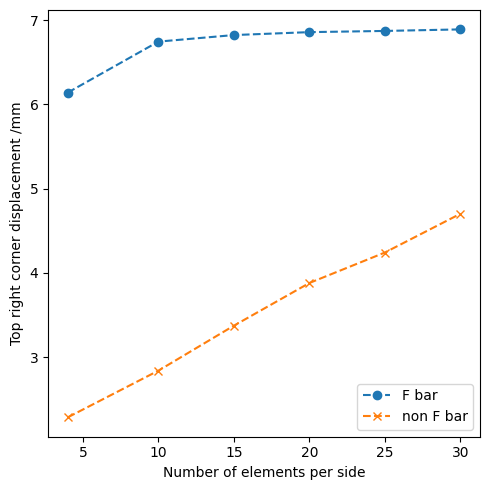

In [9]:
plot_data(uys_at_top_fbar, uys_at_top_non_fbar, "f_bar_linear.png")

### 2. Contour plot of the results

In [10]:
def contour_plot(pvd_file_name, title, fig_name=None):
    last_mesh = ot.MeshSeries(Path(out_dir, pvd_file_name))[-1]
    fig, axs = plt.subplots(1, 2, figsize=(6, 4))

    last_mesh.plot_contourf(ot.variables.displacement[1], ax=axs[0], fontsize=8)
    last_mesh.plot_contourf(ot.variables.stress["yy"], ax=axs[1], fontsize=8)
    plt.title(title)
    if fig_name:
        plt.savefig(fig_name, bbox_inches="tight", dpi=300)

#### 2.1. Non F-bar: Vertical displacement (left column) and vertical stress (right column):

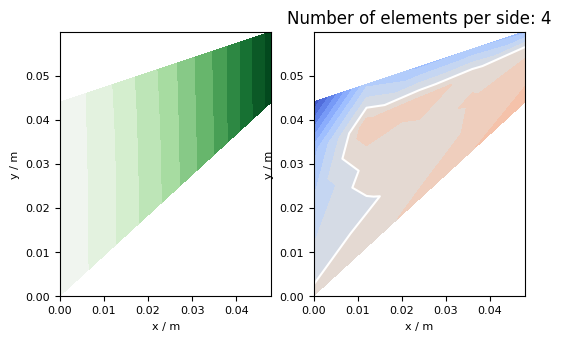

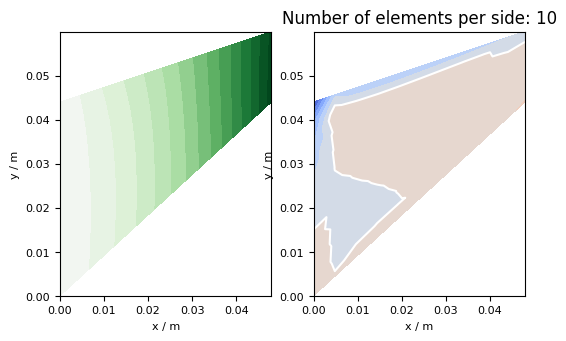

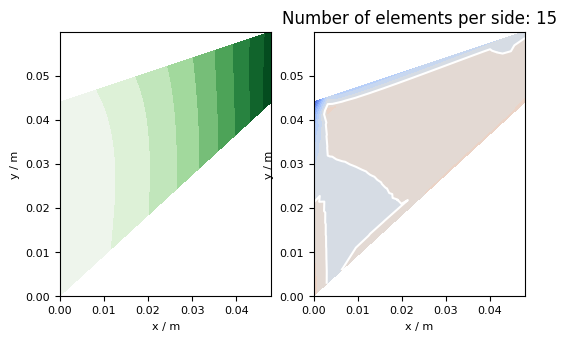

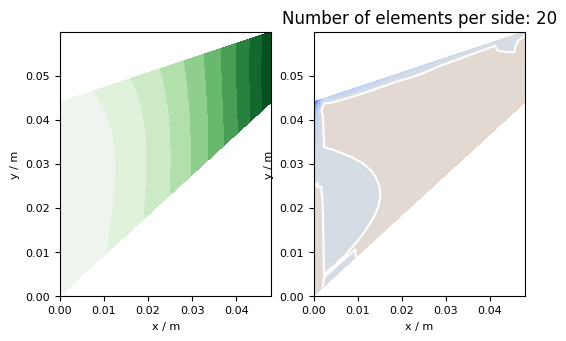

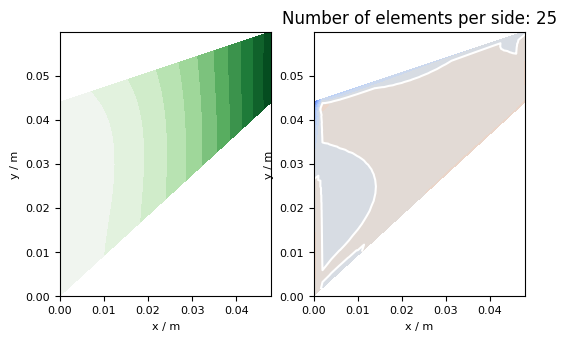

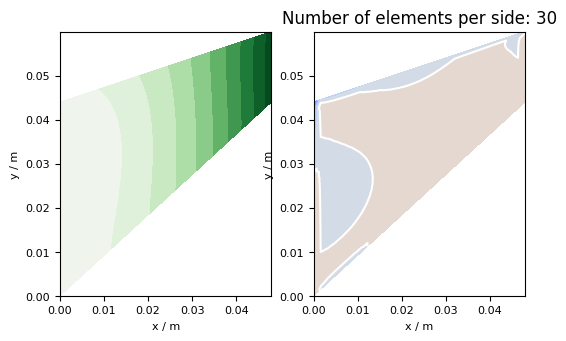

In [11]:
for nedge, output_prefix in zip(nedges, output_prefices_non_fbar):
    contour_plot(
        output_prefix + ".pvd",
        f"Number of elements per side: {nedge}",
        f"non_fbar_elements_per_side_{nedge}.png",
    )

#### 2.1. F-bar: Vertical displacement (left column) and vertical stress (right column):

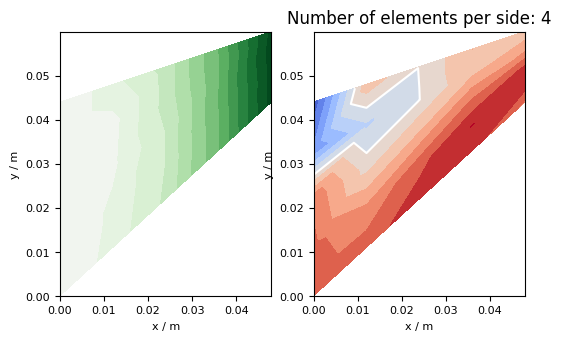

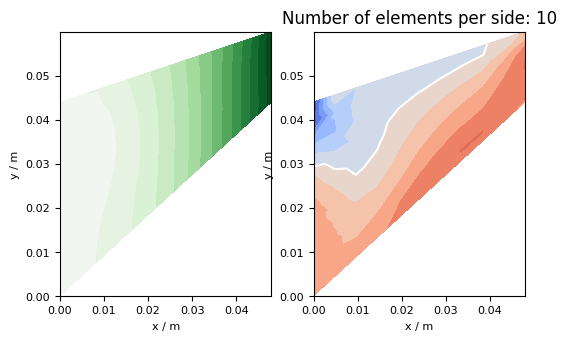

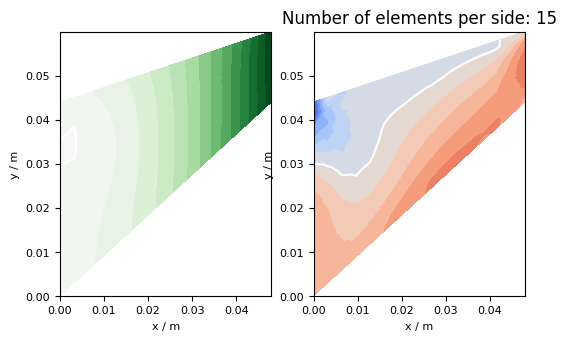

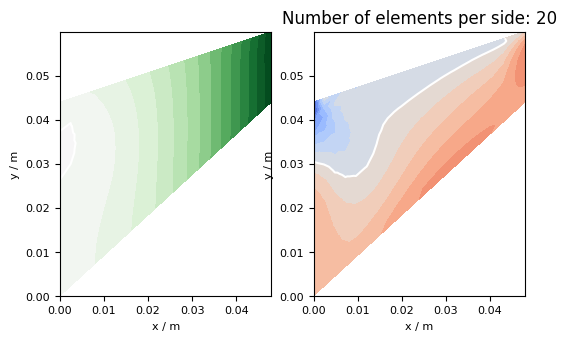

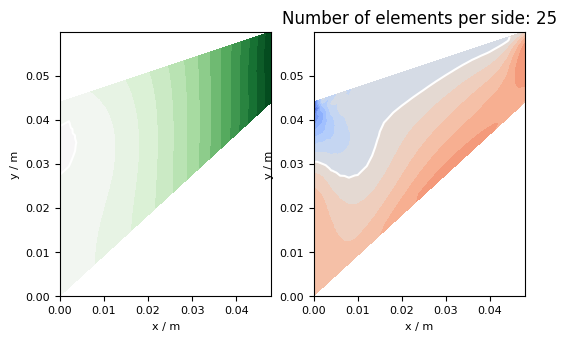

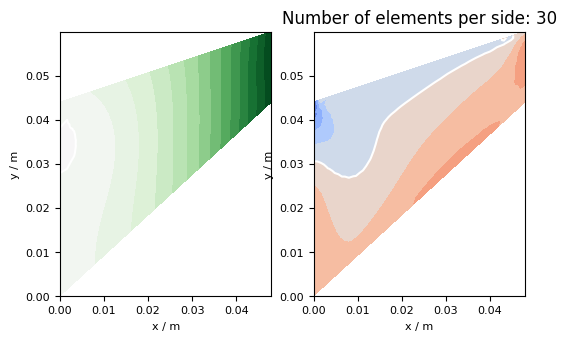

In [12]:
for nedge, output_prefix in zip(nedges, output_prefices):
    contour_plot(
        output_prefix + ".pvd",
        f"Number of elements per side: {nedge}",
        f"fbar_elements_per_side_{nedge}.png",
    )

The contour plots show that even with the coarsest mesh, the F bar method still gives reasonable stress result.